# Clonamos el repositorio para obtener los dataSet

In [1]:
!git clone https://github.com/joanby/deeplearning-az.git

Cloning into 'deeplearning-az'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 10167 (delta 35), reused 44 (delta 20), pack-reused 10096
Receiving objects: 100% (10167/10167), 236.96 MiB | 24.11 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Checking out files: 100% (10110/10110), done.


# Damos acceso a nuestro Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Test it

In [ ]:
!ls '/content/drive/My Drive' 

# Google colab tools

In [9]:
from google.colab import files # Para manejar los archivos y, por ejemplo, exportar a su navegador
import glob # Para manejar los archivos y, por ejemplo, exportar a su navegador
from google.colab import drive # Montar tu Google drive

# Instalar dependendias

In [48]:
!pip install sklearn

# Instalar Theano

In [49]:
!pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git

  Cloning git://github.com/Theano/Theano.git to /tmp/pip-req-build-cwaf9zhz
  Running command git clone -q git://github.com/Theano/Theano.git /tmp/pip-req-build-cwaf9zhz
  Created wheel for Theano: filename=Theano-1.0.5+1.geb6a4125c-cp36-none-any.whl size=2668281 sha256=16a72f1b629eac7c060fce42b066ed720b4fa7fbcd873b0fbbf0b1006755f95c
  Stored in directory: /tmp/pip-ephem-wheel-cache-tkol9apy/wheels/ae/32/7c/62beb8371953eb20c271b3bac7d0e56e1a2020d46994346b52
Successfully built Theano
  Found existing installation: Theano 1.0.5+1.geb6a4125c
    Uninstalling Theano-1.0.5+1.geb6a4125c:
      Successfully uninstalled Theano-1.0.5+1.geb6a4125c


# Instalar Tensorflow y Keras


In [50]:
!pip install keras
!pip install tensorflow

# SOM


# Cómo importar las librerías


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parte 1 - Identificar los fraudes potenciales con un SOM


In [19]:
# Usaremos el mismo SOM que programamos anteriormente, encargado de encontrar fraudes en la información cargada para solicitar tarjeta de crédito (clientes fraudulentos)

# Importar el data set


In [20]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Escalado de características

In [21]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

# Entrenar el SOM

In [22]:
import sys
sys.path.append('4 - Self Organizing Maps (SOM)')
from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5) # podemos ver si nos da mejores resultados alterando el tamaño del SOM, el sigma y el lr
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

# Visualizar los resultados


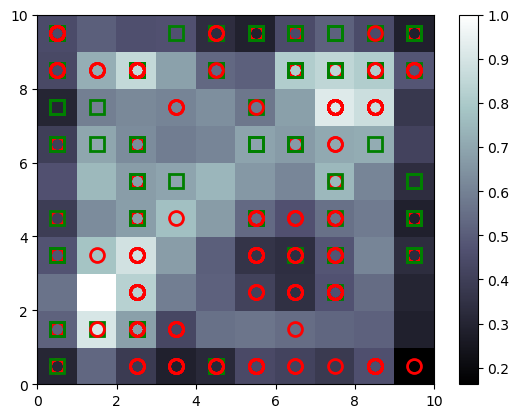

In [23]:
# En cada ejecución, me da un SOM diferente, por la inicialización aleatoria de pesos en cada nodo
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's'] # circulo rojo: tarjeta denegada, cuadrado verde: tarjeta otorgada
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0]+0.5, w[1]+0.5,
         markers[y[i]], markeredgecolor = colors[y[i]], markerfacecolor = 'None', 
         markersize = 10, markeredgewidth = 2)
show()

# Encontrar los fraudes

In [25]:
mappings = som.win_map(X)  # obtenemos las asignaciones del nodo ganador con respecto a cada cliente

# Recuperamos los fraudes del nodo (del más blanco, con menos presencia de vecinos) (outliers)
frauds_1 = mappings.get((7, 7), []) # podemos agregar más nodos blancos, según nuestro criterio

# Verificamos si la lista no está vacía
if len(frauds_1) > 0:
    frauds_1 = np.array(frauds_1)  # convertimos a un array de NumPy
    
    # Si el array es 1D, lo convertimos a 2D
    if frauds_1.ndim == 1:
        frauds_1 = frauds_1.reshape(1, -1)  # Lo convertimos en un array 2D (una fila)

    # Concatenamos (en este caso es solo un nodo, pero en general puedes agregar más nodos)
    frauds = frauds_1
    frauds = sc.inverse_transform(frauds)  # invertimos el escalado para obtener los valores originales (acá están los potenciales clientes fraudulentos)

    # Mostramos el primer elemento de cada fila de fraude (el ID de cliente, por ejemplo)
    for i in range(len(frauds)):
        print(frauds[i][0])
else:
    print("No hay observaciones en el nodo (7, 7)")

# Utilizaremos los fraudes como variable dependiente a predecir para conformar nuestra ANN (dato etiquetado)
# El SOM entrenó sin saber si eran fraudulentas o no las aplciaciones de ususarios (no incluida en matriz, aprendizaje no supervisado) 
# Sin embargo, la ANN, al ser supervisado, debe saber cuando trabaja con un caso de fraude y cuando no lo hace para que pueda identificar fraudes futuros

15662854.0
15610042.0
15568162.0
15745375.0
15638983.0
15654625.0
15662152.0
15623210.0
15734578.0
15570508.0
15795527.0
15641733.0
15660144.0
15603565.0
15664720.0
15627328.0
15800554.0
15617991.0
15696120.0
15567919.0
15687634.0
15638751.0
15641007.0
15665014.0
15606554.0


# Parte 2 - Trasladar el modelo de Deep Learning de no supervisado a supervisado


In [ ]:
# Intentaremos hacer un modelo híbrido de aprendizaje automatizado (combinando 2 modelos de DL, ANN y SOM). Esto nos permitirá obtener las probabilidades de que los clientes hayan realizados fraudes
# Trasladaremos los datos/resultados obtenidos de la SOM a un modelo supervisado, que tomará como entrada (la ANN) los resultados del SOM

# Crear la matriz de características


In [26]:
# Seguimos usando la misma X que en el SOM, a excepción del ID y la última variable del dataset (que nos decía si el cliente consiguió o no la tarjeta)
# Podemos incluir también la aceptación o no de la tarjeta si quisieramos identificar fraude solo en las aceptadas, pero procederemos en el análisis suponiendo que aceptamos todas las tarjetas (por eso eliminamos la última columna)
customers = dataset.iloc[:, 1:-1].values

# Crear la variable dependiente

In [27]:
# Crearemos la variable dependiente de si el cliente es fraudulento o no asignándole 0 en caso de que no lo sea y 1 en caso de que si
is_fraud = np.zeros(len(dataset)) # creamos nuestra VD con todos ceros
for i in range(len(dataset)): # recorremos los individuos del dataset
    if dataset.iloc[i, 0] in frauds: # ind i columna 0 (id), comprobamos si el ID de cada individuo se encuentra dentro de frauds (que contiene todas las columnas para cada individuo)
        is_fraud[i] = 1 # asignamos un 1 a las salidas que el SOM marcó como fraudulentos

In [28]:
is_fraud # comprobamos si esta con un 1 el número de individuos detectados por el SOM

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# Escalado de variables


In [29]:
# Debemos normalizar las variables para aplicar ANNs para que converga de manera efectiva y rápida
# En este caso tampoco elegimos separar el train/test (aplicamos el entrenamiento y predicción sobre todos los datos, sin comprobar eficiencia y confiando el el SOM)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
customers = sc_X.fit_transform(customers)

# Parte 2 - Construir la RNA


# Importar Keras y librerías adicionales


In [30]:
# No usaremos capas de Dropout, ya que tratamos con un problema menos complejo, y con una sola capa oculta ya nos bastaria (incluso sólo con 2 neuronas)
from keras.models import Sequential
from keras.layers import Dense

# Inicializar la RNA


In [31]:
classifier = Sequential()

# Añadir las capas de entrada y primera capa oculta


In [32]:
classifier.add(Dense(units = 2, kernel_initializer = "uniform",  activation = "relu", input_dim = 14)) # recordar que tenemos 14 columnas de entradas (X sin tomar en cuenta los ID)
# Ver en RNN para que no nos salga alerta

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Añadir la capa de salida


In [33]:
classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid"))

# Compilar la RNA

In [34]:
classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Ajustamos la RNA al Conjunto de Entrenamiento


In [35]:
# Disminuimos el batch_size a actualizaciones por cada dato procesado por la baja cantidad, lo mismo con las épocas por la simplicidad del problema
classifier.fit(customers, is_fraud,  batch_size = 1, epochs = 2) # customers es nuestro X_train y is_fraud es nuestro Y_train (no usamos datos de test)
# Como no dividimos los datos, el resultado (accuracy) que nos mostrará será el desempeño en la predicción y entrenamiento al mismo tiempo (no sabemos como rendirá ante nuevos datos)
# El no incluir datos de test nos indica que la ANN sería buena detectando probabilidades de fraude utilizando estos datos, sin hondar en su desempeño con otros

Epoch 1/2
690/690 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9659 - loss: 0.5830
Epoch 2/2
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.9595 - loss: 0.2518


# Predicción de los resultados de fraude

In [40]:
y_pred  = classifier.predict(customers) # predecimos en base a la matriz de características (con la que conseguimos el desempeño de entrenamiento también). Como no tenemos X_test, usamos la misma matriz
# y_pred nos muestra la probabilidad de que el cliente haya aportado datos fraudulentos para conseguir la tarjeta (salida sigmoid de la ANN)
y_pred = np.concatenate((dataset.iloc[:,0:1].values, y_pred), axis = 1) # agregamos los id de clientes a las probabilidades de fraudulencia identificadas con axis=1, osea columna tras columna (para saber a que cliente corresponde c/prob) (ponemos de 0:1 en vez de 0 para que me genere un vector 2D (si pongo solo 0 me lo genera 1D) y me lo pueda unir con y_pred)
y_pred = y_pred[y_pred[:,1].argsort()] # ordenamos de manera ascendente los clientes para averiguar cuales fueron los que mayor prob de fraudulencia tienen, junto con su id (argsort me ordena todas las columnas, obtenidas de y_pred, según el valor de la segunda columna de y_pred (podríamos poner otro criterio de ordenación alli))

y_pred_df = pd.DataFrame(y_pred, columns=['ID del Cliente', 'Probabilidad de Fraude']) # Transformamos y_pred en un DataFrame (mejor visualización)
pd.set_option('display.max_rows', None)  # Para mostrar todas las filas
pd.set_option('display.max_columns', None)  # Para mostrar todas las columnas
y_pred_df # nos muestra indicios de fraudes sin tener idea si efectivamente son o no (por lo menos vale la pena para investigar tales casos)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,ID del Cliente,Probabilidad de Fraude
0,15580579.0,0.012467
1,15592326.0,0.012936
2,15706602.0,0.013947
3,15722479.0,0.014280
4,15797246.0,0.015580
5,15632669.0,0.016270
6,15757306.0,0.016328
7,15640521.0,0.016502
8,15585192.0,0.016707
9,15730360.0,0.016891
